# Data Preprocessor

As we could observe in the dataValidation notebook, the data present non-uniform variations in time, that is, there is no equally spaced sampling, which complicates the time series analysis, and therefore the inference proposals. In order to correct this, a bibliographic search of NDVI curves was carried out to better discriminate the satellite images.

Our principal effort will be based on the work of Egbert et al A Comparative Analysis of Phenological Curves  for Major Crops in Kansas that states:

> The results seem to suggest that time-series NDVI response curves for crops over a growing period for one year of valid ground  reference data may be useful for mapping crops for a different year when minor temporal shifts in the NDVI values (resulting from inter-annual climate varia-tions or changes in agricultural management practices) are taken into account.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pathlib
import operator
import os

from typing import Union, List
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

In [2]:
def load_ndvi_data(
    filename : str
) -> pd.DataFrame:
    BASE_DIR ='/home/aargaez/Downloads/Plant-Growth-Cycle-based-on-geospatial-data/NdviCharts/'
    path = pathlib.Path(BASE_DIR)
    files = [f.name for f in path.glob('**/*.csv')]

    for f in files:
        if filename in f:
            directory = BASE_DIR + f
            data = pd.read_csv(directory)
            data.rename(columns={'x':'time', 'y':'NDVI'}, inplace=True)
            return data

In [3]:
# Load the data.
ndvi2001 = load_ndvi_data('ndvi2001Masialeti')
ndvi2005 = load_ndvi_data('ndvi2005Masialeti')
ndvi2012 = load_ndvi_data('ndvi2012Johnson')
ndvi2018 = load_ndvi_data('ndvi2018Johnson')
ndvi2019 = load_ndvi_data('ndvi2019Johnson')
ndvi2020 = load_ndvi_data('ndvi2020Johnson')

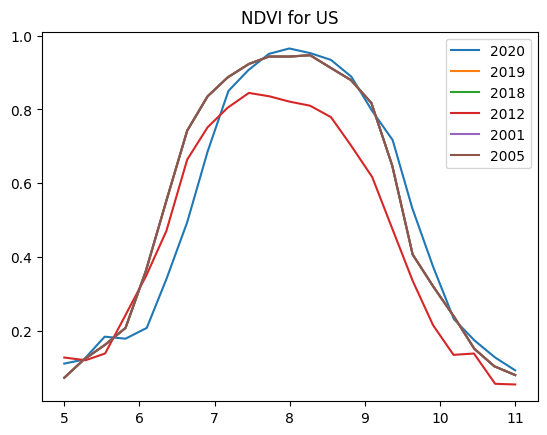

In [4]:
plt.plot(ndvi2020['time'], ndvi2020['NDVI'], label='2020')
plt.plot(ndvi2018['time'], ndvi2018['NDVI'], label='2019')
plt.plot(ndvi2018['time'], ndvi2018['NDVI'], label='2018')
plt.plot(ndvi2012['time'], ndvi2012['NDVI'], label='2012')
plt.plot(ndvi2018['time'], ndvi2018['NDVI'], label='2001')
plt.plot(ndvi2018['time'], ndvi2018['NDVI'], label='2005')
plt.legend()
plt.title('NDVI for US')
plt.show()

Looking all the NDVI curves we can pursue an analytical function that helps of us to rectify our extracted images. For this porpuse, we shall assume that the NDVI provided data fulfill the Gauss-Markov theorem and that the system could be write as:

$$\vec{y} = X\vec{B} + \vec{\epsilon}$$
$$\vec{B} = (X^{T} X)^{-1}X^{T}\vec{y}$$

under the assumption $m \geq n$

In [5]:
# Polinomial Regression.
def polynomial_regression(
    x: Union[List, np.array],
    y: Union[List, np.array],
    degree: int = 2
):
    # Transforming the data to include another axis
    x = np.array(x).reshape(len(x), 1)
    y = np.array(y).reshape(len(y), 1)

    polynomial_features = PolynomialFeatures(degree=degree)
    x_poly = polynomial_features.fit_transform(x)

    model = LinearRegression()
    model.fit(x_poly, y)
    y_poly_pred = model.predict(x_poly)

    # Get the coefficients and the intercept.
    coefficients = model.coef_
    intercept = model.intercept_
    
    # Root Mean Square Error.
    rmse = np.sqrt(mean_squared_error(y, y_poly_pred))
    
    # Coefficient of determination.
    r2 = r2_score(y,y_poly_pred)

    plt.scatter(x, y, s=10)

    # Sort the values of x before line plot
    sort_axis = operator.itemgetter(0)
    sorted_zip = sorted(zip(x, y_poly_pred), key=sort_axis)
    x, y_poly_pred = zip(*sorted_zip)
    plt.plot(x, y_poly_pred, color='m')
    plt.show()
    
    return rmse, r2, y_poly_pred, coefficients, intercept

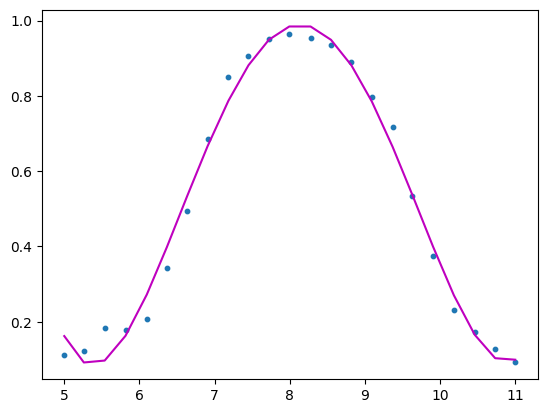

In [6]:
rmse, r2, y_predicted, coeficients, intercept = polynomial_regression(ndvi2020['time'], ndvi2020['NDVI'], 4)

In [7]:
# Save the predicted values to an txt file.

In [8]:
import sympy
sympy.init_printing()
x = sympy.Symbol('x')

In [9]:
coeficients = coeficients.reshape(-1)

polynomial = coeficients[0] + coeficients[1]*x + coeficients[2]*x**2 + coeficients[3]*x**3 + coeficients[4]*x**4

polynomial